# Modelización

**Resumen** Entrada de variables en el modelo: 

Leyennda:
* **Candidata**: variable a incluir en los modelos.
* **Descartada**: variable que NO vamos a incluir en los modelos.
* **No candidata**: variable que vamos a valorar si meterla en los modelos tras la evaluación inicial con las variables candidatas. Si consideramos que pueden mejorar el modelo, las incluiremos.


**Entrada de variables en el modelo:**

* Age - **Candidata**           Correlación 0.34
* Tenure - **Descartada**       Correlación -0.01
* NumOfProducts - **Candidata**       Correlación -0.20
* IsActiveMember - **Candidata**       Correlación -0.21
* Sex - **Candidata**       Correlación -0.14
* CreditScore - **Descartada**      Correlación -0.03
* Balance - **Candidata**       Correlación 0.13
* Countries - **Candidata** Por lo explicado en Tabla7 y Grafico1
* EstimatedSalary - **Descartada**      Correlación 0.02
* HasCrCard - **Descartada**        Correlación -0.02

* Tenure_Age - **Descartada**       Correlación -0.13
* Age_Tenure_product - **Descartada**       Correlación 0.11
* Mem__no__Products - **No Candidata**       Correlación -0.23
* Cred_Bal_Sal - **No Candidata**       Correlación 0.10
* Bal_sal - **No Candidata**       Correlación 0.11

Modelos a probar:

* Regresión logística

* Random forest

* Naive Bayes

 

Carga de librerías y de datos - no incluir proyecto final

In [1]:
import requests
import pandas as pd
from io import StringIO
import time 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest, chi2

from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, r2_score

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
url="/workspaces/Isa-Project/data/data_clean.csv"
data_clean=pd.read_csv(url)

#observamos que se hayan cargado correctamente los datos con las primeras 5 filas del dataset
data_clean.head()

,Unnamed: 0,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Mem__no__Products,Age_Tenure_product,Sex,Countries,Tenure_Age_calc,Cred_Bal_Sal_out,Bal_sal_out
0,0,668.0,33.0,3.0,0.00,2.0,1,0,181449.97,0,0.0,99.0,1,1,0.090909,0.000000,0.000000
1,1,627.0,33.0,1.0,0.00,2.0,1,1,49503.50,0,2.0,33.0,1,1,0.030303,0.000000,0.000000
2,2,678.0,40.0,10.0,0.00,2.0,1,0,184866.69,0,0.0,400.0,1,1,0.250000,0.000000,0.000000
3,3,581.0,34.0,2.0,148882.54,1.0,1,1,84560.88,0,1.0,68.0,1,1,0.058824,1022.940581,1.760655
4,4,716.0,33.0,5.0,0.00,2.0,1,1,15068.83,0,2.0,165.0,1,3,0.151515,0.000000,0.000000


Vamos a crear un data set con las variables a incluir iniciales: Age, NumOfProducts, IsActiveMember, Sex, Balance, Countries. 

[Posibles candidatas: Mem__no__Products, Cred_Bal_Sal, Bal_sal]


In [4]:
vars_mod1=["Age", "NumOfProducts", "IsActiveMember", "Sex", "Balance", "Countries"]
vars_mod_aux= ["Mem__no__Products", "Cred_Bal_Sal", "Bal_sal"]

Separamos la muestra test y de entrenamiento: X lleva las variables iniciales Candidatas

In [5]:
y=data_clean["Exited"]
X=data_clean[vars_mod1]

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

Normalizamos los datos

In [6]:
 
scaler = StandardScaler()
scaler.fit(X_train)

cols=X.columns
X_train_norm = scaler.transform(X_train)
X_train_norm = pd.DataFrame(X_train_norm, index = X_train.index, columns = cols)

X_test_norm = scaler.transform(X_test)
X_test_norm = pd.DataFrame(X_test_norm, index = X_test.index, columns = cols)



Modelo de regresión logistica y 

In [7]:
#Regresión
model = LogisticRegression()
model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)

#Lasso
lasso_model = Lasso(alpha = 0.1, max_iter = 300)
lasso_model.fit(X_train_norm, y_train)
y_pred_lasso = lasso_model.predict(X_test_norm)

#Ridge
ridge_model = Ridge(alpha = 0.1, max_iter = 300)
ridge_model.fit(X_train_norm, y_train)
y_pred_ridge = ridge_model.predict(X_test_norm)

In [8]:
def descriptive (arr):
    return print(pd.DataFrame({
        'mean':np.mean(arr),
        'median':np.quantile(arr,0.5),
        '75%':np.quantile(arr,0.75),
        'max':np.max(arr),
        'min':np.min(arr)
        }

        ,index=[0]))
    

In [11]:
descriptive(y_pred_ridge),descriptive(y_pred_lasso),descriptive(y_test),descriptive(y_pred),descriptive(y)

       mean    median       75%       max       min
0  0.210741  0.196513  0.331463  1.089923 -0.283833
       mean    median       75%       max       min
0  0.211186  0.206486  0.227165  0.433959  0.127904
       mean  median  75%  max  min
0  0.210418     0.0  0.0    1    0
       mean  median  75%  max  min
0  0.103552     0.0  0.0    1    0
       mean  median  75%  max  min
0  0.211178     0.0  0.0    1    0


(None, None, None, None, None)

0.8254707546361116
[[26449  1184]
 [ 4924  2440]]
[[27633     0]
 [ 7364     0]]
[[26860   773]
 [ 5599  1765]]


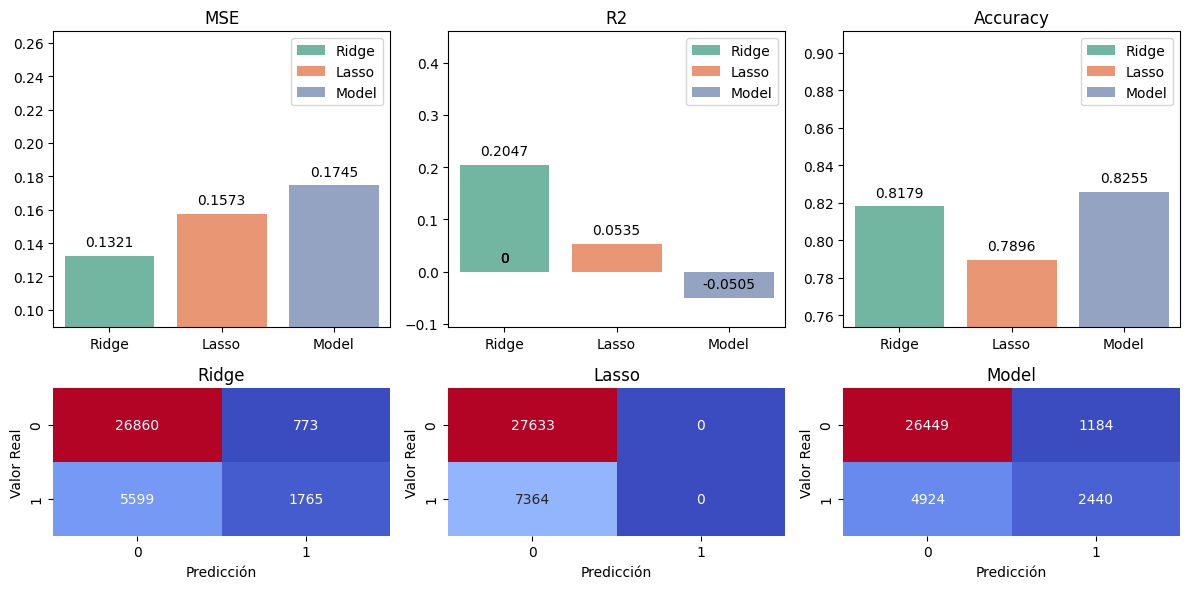

In [32]:
y_pred_ridge_round=y_pred_ridge.round(0)
y_pred_lasso_round=y_pred_lasso.round(0)
# Calcular el error cuadrático medio
ridge_mse = mean_squared_error(y_test, y_pred_ridge)
lasso_mse = mean_squared_error(y_test, y_pred_lasso)
MSE= mean_squared_error(y_test, y_pred)

ridge_r2=r2_score(y_test, y_pred_ridge)
lasso_r2=r2_score(y_test, y_pred_lasso)
R2=r2_score(y_test, y_pred)


ridge_acc=accuracy_score(y_test, y_pred_ridge_round)
lasso_acc=accuracy_score(y_test, y_pred_lasso_round)
model_acc=accuracy_score(y_test, y_pred)

ridge_conf=cm = confusion_matrix(y_test, y_pred_ridge_round)
lasso_conf=confusion_matrix(y_test, y_pred_lasso_round)
model_conf=confusion_matrix(y_test, y_pred)

valoresMSE=[ridge_mse,lasso_mse,MSE]
valoresR2=[ridge_r2,lasso_r2,R2]
valoresAcc=[ridge_acc,lasso_acc,model_acc]

nombs=['Ridge','Lasso','Model']

# Graficamos los datos resultados
print(model_acc)
print(model_conf)
print(lasso_conf)
print(ridge_conf)

fig, axis= plt.subplots(2,3,figsize=(12,6), gridspec_kw={'height_ratios': [2, 1]})

#FILA 0
## 1º GRÁFICO

ax1=sns.barplot(x=nombs,y=valoresMSE,hue=nombs,ax=axis[0,0],legend=nombs,palette="Set2")
lim0=min(valoresMSE)-(max(valoresMSE)-min(valoresMSE))
lim1=max(valoresMSE)+(max(valoresMSE)-min(valoresMSE))+0.05
for p in ax1.patches:
    ax1.annotate(f'{round(p.get_height(),4)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

axis[0,0].set_ylim(lim0,lim1)
axis[0,0].set_title("MSE")

## 2º GRÁFICO
ax2=sns.barplot(x=nombs,y=valoresR2,hue=nombs,ax=axis[0,1],legend=nombs,palette="Set2")
lim0=min(valoresR2)-(max(valoresR2)-min(valoresR2))+0.2
lim1=max(valoresR2)+(max(valoresR2)-min(valoresR2))
for p in ax2.patches:
    ax2.annotate(f'{round(p.get_height(),4)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')


axis[0,1].set_ylim(lim0,lim1)
axis[0,1].set_title("R2")

## 3º GRÁFICO
ax2=sns.barplot(x=nombs,y=valoresAcc,hue=nombs,ax=axis[0,2],legend=nombs,palette="Set2")
lim0=min(valoresAcc)-(max(valoresAcc)-min(valoresAcc))
lim1=max(valoresAcc)+(max(valoresAcc)-min(valoresAcc))+0.05
for p in ax2.patches:
    ax2.annotate(f'{round(p.get_height(),4)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')


axis[0,2].set_ylim(lim0,lim1)
axis[0,2].set_title("Accuracy")

#FILA 1
## 1º GRÁFICO

sns.heatmap(ridge_conf, annot=True, fmt='g', cmap='coolwarm', cbar=False, ax=axis[1,0],
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])

axis[1,0].set_xlabel('Predicción')
axis[1,0].set_ylabel('Valor Real')
axis[1,0].set_title('Ridge')

sns.heatmap(lasso_conf, annot=True, fmt='g', cmap='coolwarm', cbar=False, ax=axis[1,1],
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])

axis[1,1].set_xlabel('Predicción')
axis[1,1].set_ylabel('Valor Real')
axis[1,1].set_title('Lasso')

sns.heatmap(model_conf, annot=True, fmt='g', cmap='coolwarm', cbar=False, ax=axis[1,2],
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])

axis[1,2].set_xlabel('Predicción')
axis[1,2].set_ylabel('Valor Real')
axis[1,2].set_title('Model')

plt.tight_layout()
plt.show()

